Title: **Assignment 2 - COSC3013 Computational Machine Learning - End-to-end Machine Learning Project**

Student ID: **S3979613**

Student Name and email (contact info): **Dao Sy Trung Kien - S3979613@rmit.edu.vn**

Affiliations: **RMIT University Vietnam.**

Date of Report: 03/08/2023

I certify that this is all my own original work. If I took any parts from elsewhere, then they were non-essential parts of the assignment, and they are clearly attributed in my submission.  I will show I agree to this honor code by typing "Yes": Yes.

Please start your report here. 

### Required Libraries and Utilities

In [1]:
# Importing packages - Pandas, Numpy, Seaborn, Scipy, Impute
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
import matplotlib.style as style; style.use('fivethirtyeight')
np.random.seed(0)
from sklearn.impute import SimpleImputer

# Modelling
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# Oversampling
from imblearn.over_sampling import SMOTE

# Suppress warnings
import warnings; warnings.filterwarnings('ignore')
pd.options.display.max_rows = 4000

### Import data and check for null values.

In [2]:
# Code for import data from Paitients_Files_Train csv file
# df_train = pd.read_csv(r'C:\Users\Kien\Downloads\Computational ML\UCI-electricity\UCI-electricity\UCI_data.csv')
df_train = pd.read_csv(r'UCI_data.csv')
# Print out data.
df_train.head()

,date,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,...,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,TARGET_energy
0,2016-04-19 20:30:00,22.200000,39.500000,20.566667,37.656667,22.230000,37.030000,22.318571,36.610000,20.633333,...,33.90,9.70,766.100000,65.5,3.500000,40.000000,3.350000,24.061869,24.061869,60
1,2016-03-05 04:40:00,20.356667,37.126667,17.566667,40.230000,20.890000,37.663333,18.700000,36.260000,18.463333,...,41.09,0.30,740.333333,99.0,1.000000,41.333333,0.100000,4.622052,4.622052,50
2,2016-03-14 12:40:00,20.926667,38.790000,21.100000,35.526667,21.600000,36.290000,21.000000,34.826667,18.100000,...,38.76,4.40,768.466667,72.0,6.000000,22.666667,-0.266667,5.635898,5.635898,80
3,2016-01-22 15:30:00,18.290000,38.900000,17.290000,39.260000,18.390000,39.326667,16.100000,38.790000,16.100000,...,39.20,3.35,760.600000,82.0,5.500000,41.000000,0.500000,49.216445,49.216445,40
4,2016-02-10 00:40:00,22.290000,42.333333,21.600000,40.433333,22.666667,43.363333,19.100000,40.900000,19.290000,...,43.73,3.20,738.900000,88.0,7.333333,56.000000,1.400000,47.617579,47.617579,60


In [3]:
# Calculating the Missing Values % contribution in Train Data
df_train_null = round(100*(df_train.isnull().sum())/len(df_train), 2)
df_train_null

date             0.0
T1               0.0
RH_1             0.0
T2               0.0
RH_2             0.0
T3               0.0
RH_3             0.0
T4               0.0
RH_4             0.0
T5               0.0
RH_5             0.0
T6               0.0
RH_6             0.0
T7               0.0
RH_7             0.0
T8               0.0
RH_8             0.0
T9               0.0
RH_9             0.0
T_out            0.0
Press_mm_hg      0.0
RH_out           0.0
Windspeed        0.0
Visibility       0.0
Tdewpoint        0.0
rv1              0.0
rv2              0.0
TARGET_energy    0.0
dtype: float64

### Basic Data Exploration and Data Cleansing.

In [4]:
# Check the dimensions of the Training dataset
print(df_train.shape)

(19735, 28)


In [5]:
# Get info of the dataframe columns
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 28 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           19735 non-null  object 
 1   T1             19735 non-null  float64
 2   RH_1           19735 non-null  float64
 3   T2             19735 non-null  float64
 4   RH_2           19735 non-null  float64
 5   T3             19735 non-null  float64
 6   RH_3           19735 non-null  float64
 7   T4             19735 non-null  float64
 8   RH_4           19735 non-null  float64
 9   T5             19735 non-null  float64
 10  RH_5           19735 non-null  float64
 11  T6             19735 non-null  float64
 12  RH_6           19735 non-null  float64
 13  T7             19735 non-null  float64
 14  RH_7           19735 non-null  float64
 15  T8             19735 non-null  float64
 16  RH_8           19735 non-null  float64
 17  T9             19735 non-null  float64
 18  RH_9  

In [6]:
# Convert the datetime column to a pandas datetime object
df_train['datetime'] = pd.to_datetime(df_train['date'])

# Create new columns for date and time
df_train['date'] = df_train['datetime'].dt.date
df_train['time'] = df_train['datetime'].dt.time

#Hour of the Day
df_train['hour'] = df_train['datetime'].dt.hour

# Day Part
df_train['day_part'] = pd.cut(df_train['hour'], bins=[0, 6, 12, 18, 24], labels=['Night', 'Morning', 'Afternoon', 'Evening'], right=False)

# Season
df_train['month'] = df_train['datetime'].dt.month
df_train['season'] = df_train['month'].apply(lambda x: 'Winter' if x in [12, 1, 2] else 'Spring' if x in [3, 4, 5] else 'Summer' if x in [6, 7, 8] else 'Fall')

# Drop the original datetime column if no longer needed
df_train.drop('datetime', axis=1, inplace=True)

In [7]:
# Encode the 'day_part' categorical feature into numerical values
df_train['day_part_encoded'] = df_train['day_part'].cat.codes
df_train['day_part_encoded']

0        3
1        0
2        2
3        2
4        0
        ..
19730    1
19731    1
19732    1
19733    1
19734    1
Name: day_part_encoded, Length: 19735, dtype: int8

In [8]:

# Calculate the median temperature and humidity for each day_part
temperature_columns = ['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9']
humidity_columns = ['RH_1', 'RH_2', 'RH_3', 'RH_4', 'RH_5', 'RH_6', 'RH_7', 'RH_8', 'RH_9']

# Group by 'day_part' and calculate the median for temperature and humidity columns
median_temperature_inside = df_train.groupby('day_part')[temperature_columns].median().mean(axis=1).reset_index(name='median_temperature_inside')
median_temperature_outside = df_train.groupby('day_part')['T_out'].median().reset_index(name='median_temperature_outside')
median_humidity_inside = df_train.groupby('day_part')[humidity_columns].median().mean(axis=1).reset_index(name='median_humidity_inside')
median_humidity_outside = df_train.groupby('day_part')['RH_out'].median().reset_index(name='median_humidity_outside')

# Merge the median values back into the original DataFrame
df_train = df_train.merge(median_temperature_inside, on='day_part', how='left')
df_train = df_train.merge(median_temperature_outside, on='day_part', how='left')
df_train = df_train.merge(median_humidity_inside, on='day_part', how='left')
df_train = df_train.merge(median_humidity_outside, on='day_part', how='left')


In [9]:
# Get info of the dataframe columns
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 38 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   date                        19735 non-null  object  
 1   T1                          19735 non-null  float64 
 2   RH_1                        19735 non-null  float64 
 3   T2                          19735 non-null  float64 
 4   RH_2                        19735 non-null  float64 
 5   T3                          19735 non-null  float64 
 6   RH_3                        19735 non-null  float64 
 7   T4                          19735 non-null  float64 
 8   RH_4                        19735 non-null  float64 
 9   T5                          19735 non-null  float64 
 10  RH_5                        19735 non-null  float64 
 11  T6                          19735 non-null  float64 
 12  RH_6                        19735 non-null  float64 
 13  T7              

In [10]:
# Five point summary of numerical attributes
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
T1,19735.0,21.686571,1.606066,16.790000,20.760000,21.600000,22.600000,26.260000
RH_1,19735.0,40.259739,3.979299,27.023333,37.333333,39.656667,43.066667,63.360000
T2,19735.0,20.341219,2.192974,16.100000,18.790000,20.000000,21.500000,29.856667
RH_2,19735.0,40.420420,4.069813,20.463333,37.900000,40.500000,43.260000,56.026667
T3,19735.0,22.267611,2.006111,17.200000,20.790000,22.100000,23.290000,29.236000
RH_3,19735.0,39.242500,3.254576,28.766667,36.900000,38.530000,41.760000,50.163333
T4,19735.0,20.855335,2.042884,15.100000,19.530000,20.666667,22.100000,26.200000
RH_4,19735.0,39.026904,4.341321,27.660000,35.530000,38.400000,42.156667,51.090000
T5,19735.0,19.592106,1.844623,15.330000,18.277500,19.390000,20.619643,25.795000
RH_5,19735.0,50.949283,9.022034,29.815000,45.400000,49.090000,53.663333,96.321667


In [11]:
median_windspeed = df_train['Windspeed'].median()
# Replace missing values with median
df_train['Windspeed'].replace(0, median_windspeed, inplace=True)

In [12]:
df_train[['day_part','median_temperature_inside','median_temperature_outside','median_humidity_outside','median_humidity_inside']]

,day_part,median_temperature_inside,median_temperature_outside,median_humidity_outside,median_humidity_inside
0,Evening,19.458148,7.233333,80.833333,41.411667
1,Night,18.818102,5.133333,89.833333,43.742320
2,Afternoon,19.666481,9.350000,67.000000,38.619211
3,Afternoon,19.666481,9.350000,67.000000,38.619211
4,Night,18.818102,5.133333,89.833333,43.742320
...,...,...,...,...,...
19730,Morning,18.753951,6.100000,88.000000,43.192269
19731,Morning,18.753951,6.100000,88.000000,43.192269
19732,Morning,18.753951,6.100000,88.000000,43.192269
19733,Morning,18.753951,6.100000,88.000000,43.192269


### Features Engineer

In [14]:
from sklearn.preprocessing import MinMaxScaler
# Initialize the Min-Max Scaler
scaler = MinMaxScaler()
# Identify numerical features for normalization
features_to_normalize = df_train.drop(columns=['date', 'time', 'day_part','season']).columns

# Apply the scaler to the selected features
df_train[features_to_normalize] = scaler.fit_transform(df_train[features_to_normalize])

In [15]:
df_train[features_to_normalize].describe()

,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,...,rv1,rv2,TARGET_energy,hour,month,day_part_encoded,median_temperature_inside,median_temperature_outside,median_humidity_inside,median_humidity_outside
count,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,...,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000
mean,0.517061,0.364271,0.308303,0.561170,0.421038,0.489601,0.518499,0.485143,0.407272,0.317777,...,0.499742,0.499742,0.083179,0.500087,0.525412,0.500076,0.460679,0.431994,0.609237,0.631194
std,0.169595,0.109512,0.159412,0.114438,0.166676,0.152107,0.184044,0.185289,0.176266,0.135656,...,0.289984,0.289984,0.094892,0.300954,0.334800,0.372650,0.433695,0.372471,0.390052,0.393257
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.419219,0.283735,0.195542,0.490299,0.298272,0.380122,0.399099,0.335894,0.281653,0.234337,...,0.249895,0.249895,0.036364,0.260870,0.250000,0.333333,0.070300,0.229249,0.000000,0.000000
50%,0.507920,0.347675,0.283499,0.563408,0.407112,0.456302,0.501502,0.458387,0.387960,0.289821,...,0.497934,0.497934,0.045455,0.521739,0.500000,0.666667,0.771697,0.498024,0.545071,0.605839
75%,0.613516,0.441519,0.392537,0.641016,0.505982,0.607260,0.630631,0.618722,0.505460,0.358586,...,0.751701,0.751701,0.081818,0.739130,0.750000,0.666667,1.000000,1.000000,0.892633,0.919708
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


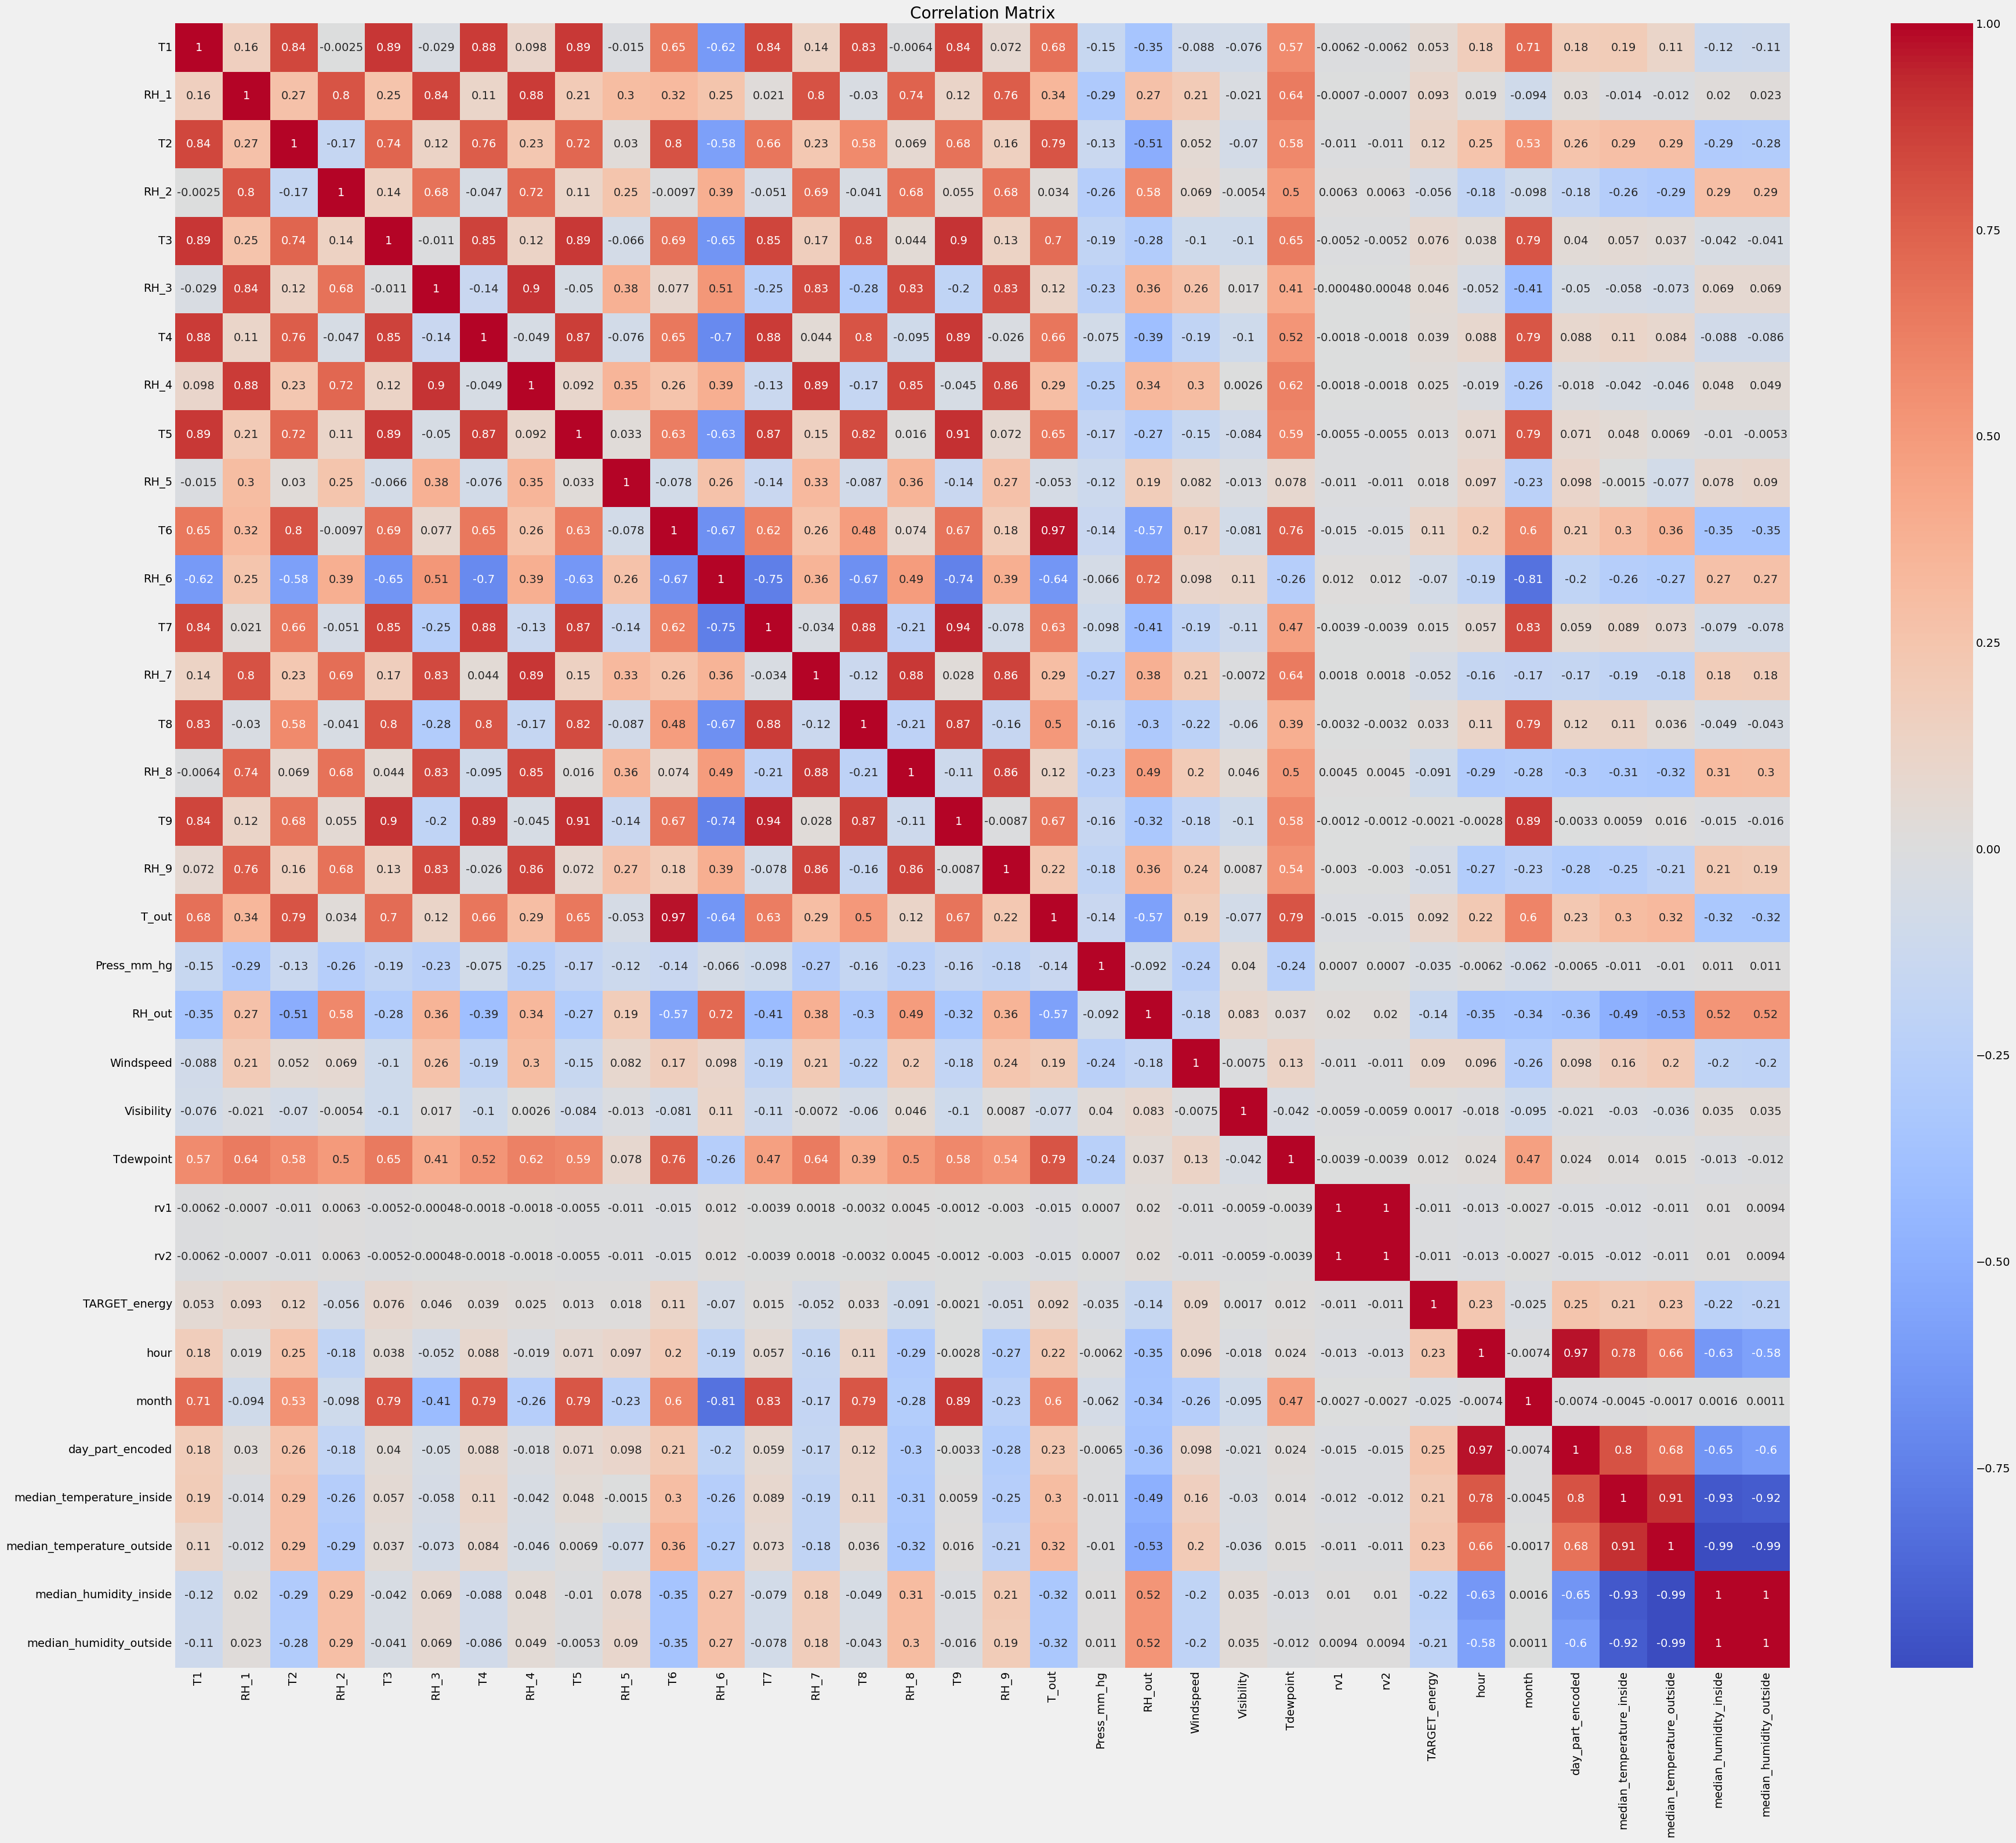

In [16]:
# Correlation Matrix after normalization
numeric_df_train = df_train[features_to_normalize].select_dtypes(include=[np.number])
plt.figure(figsize=(40, 35))
sns.heatmap(numeric_df_train.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()
